    RANDOM FOREST

Accuracy: 0.9100
Precision: 0.9149
Recall: 0.8958
F1 Score: 0.9053
ROC-AUC Score: 0.9379


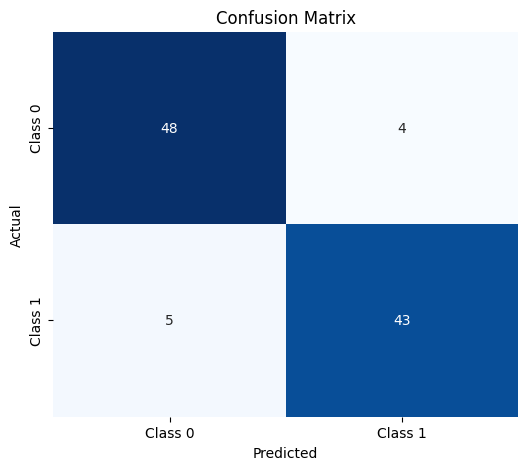

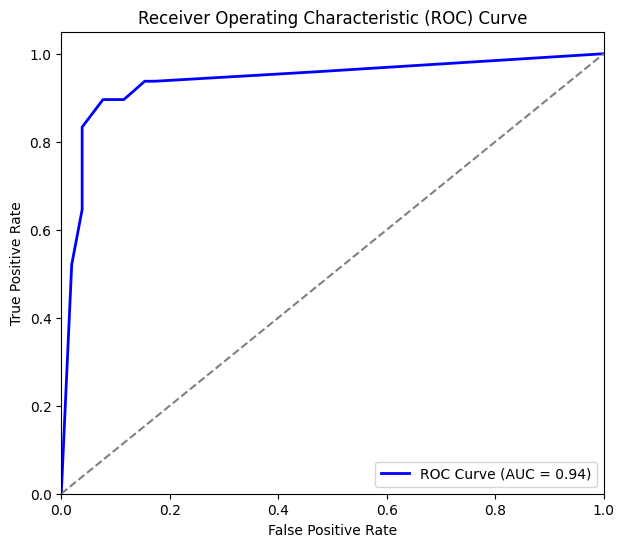

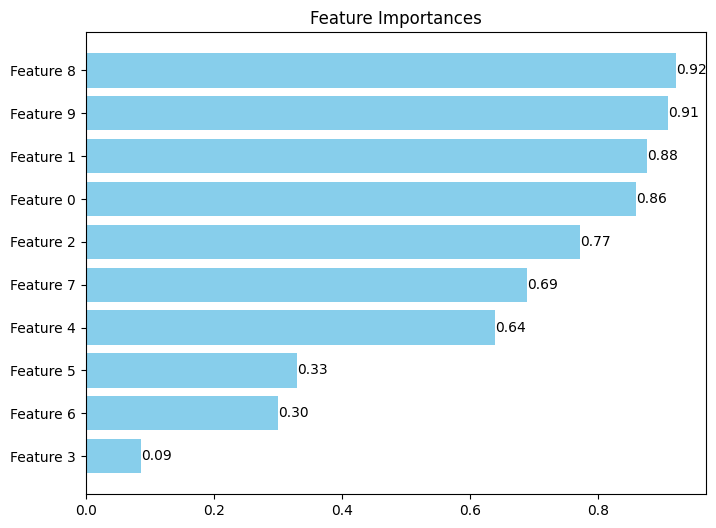

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.datasets import make_classification  # To generate sample data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import seaborn as sns

# Helper function to calculate Gini Impurity
def gini_impurity(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

# Function to calculate information gain
def information_gain(y, left_indices, right_indices):
    parent_loss = gini_impurity(y)
    n = len(y)
    n_left, n_right = len(left_indices), len(right_indices)
    if n_left == 0 or n_right == 0:
        return 0
    left_loss = gini_impurity(y[left_indices])
    right_loss = gini_impurity(y[right_indices])
    child_loss = (n_left / n) * left_loss + (n_right / n) * right_loss
    return parent_loss - child_loss

# Decision Tree Node
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left = left
        self.right = right
        self.value = value

# Decision Tree Classifier
class DecisionTreeClassifier:
    def __init__(self, max_depth=10, min_samples_split=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = self.n_features or X.shape[1]
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if (depth >= self.max_depth or n_samples < self.min_samples_split or len(set(y)) == 1):
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)

        feature_indices = np.random.choice(n_features, self.n_features, replace=False)
        best_feature, best_thresh = self._best_criteria(X, y, feature_indices)
        left_indices, right_indices = self._split(X[:, best_feature], best_thresh)
        
        if len(left_indices) == 0 or len(right_indices) == 0:
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)
        
        left = self._grow_tree(X[left_indices, :], y[left_indices], depth + 1)
        right = self._grow_tree(X[right_indices, :], y[right_indices], depth + 1)
        return DecisionTreeNode(best_feature, best_thresh, left, right)

    def _best_criteria(self, X, y, feature_indices):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feature_index in feature_indices:
            X_column = X[:, feature_index]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                left_indices, right_indices = self._split(X_column, threshold)
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue
                gain = information_gain(y, left_indices, right_indices)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_index
                    split_thresh = threshold
        return split_idx, split_thresh

    def _split(self, X_column, threshold):
        left_indices = np.argwhere(X_column <= threshold).flatten()
        right_indices = np.argwhere(X_column > threshold).flatten()
        return left_indices, right_indices

    def _most_common_label(self, y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

# Random Forest Classifier
class RandomForestClassifier:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTreeClassifier(max_depth=self.max_depth, 
                                          min_samples_split=self.min_samples_split, 
                                          n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_predictions)

# Create a sample classification dataset
X, y = make_classification(n_samples=500, n_features=10, n_classes=2, random_state=42)

# Split dataset into training and test sets
split_ratio = 0.8
split_index = int(X.shape[0] * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train Random Forest
rf = RandomForestClassifier(n_trees=10, max_depth=10, n_features=3)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluation Metrics

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)

# 2. Precision
precision = precision_score(y_test, y_pred)

# 3. Recall
recall = recall_score(y_test, y_pred)

# 4. F1 Score
f1 = f1_score(y_test, y_pred)

# 5. ROC-AUC Score (Need probability predictions, assuming binary classification)
y_pred_prob = np.mean([tree.predict(X_test) for tree in rf.trees], axis=0)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# 6. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display all metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature Importance (Simulated for illustration)
def plot_feature_importance(importances, feature_names, title="Feature Importances"):
    sorted_indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center', color='skyblue')
    plt.yticks(range(len(sorted_indices)), np.array(feature_names)[sorted_indices])
    plt.gca().invert_yaxis()  # To have the highest importance on top
    plt.title(title)
    for i, v in enumerate(importances[sorted_indices]):
        plt.text(v, i, f"{v:.2f}", color='black', va='center')
    plt.show()

# Simulated random importances for illustration
feature_importances = np.random.rand(10)
plot_feature_importance(feature_importances, feature_names=[f"Feature {i}" for i in range(10)])


    NAIVE BAYES

In [14]:
import numpy as np

# Step 1: Naive Bayes Implementation

class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # Initialize mean, variance, and prior
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            class_conditional = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + class_conditional
            posteriors.append(posterior)

        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(- (x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

# Step 2: Metrics Implementation

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def precision(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    predicted_positives = np.sum(y_pred == 1)
    return true_positives / predicted_positives

def recall(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    actual_positives = np.sum(y_true == 1)
    return true_positives / actual_positives

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r)

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

def roc_auc_score(y_true, y_prob):
    thresholds = np.unique(y_prob)
    tprs = []
    fprs = []
    for thresh in thresholds:
        y_pred_thresh = (y_prob >= thresh).astype(int)
        tp = np.sum((y_true == 1) & (y_pred_thresh == 1))
        fn = np.sum((y_true == 1) & (y_pred_thresh == 0))
        fp = np.sum((y_true == 0) & (y_pred_thresh == 1))
        tn = np.sum((y_true == 0) & (y_pred_thresh == 0))

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)

        tprs.append(tpr)
        fprs.append(fpr)

    tprs = np.array(tprs)
    fprs = np.array(fprs)
    auc = np.trapz(tprs, fprs)
    return auc

# Step 3: Testing the Model and Metrics

# Generate a small synthetic dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=10, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes Classifier
nb = NaiveBayes()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Probability predictions for ROC-AUC score
y_prob = np.array([np.max([np.exp(np.sum(np.log(nb._pdf(i, x)))) for i in range(len(nb._classes))]) for x in X_test])

# Step 4: Calculate and Display the Metrics
print("Accuracy:", accuracy(y_test, y_pred))
print("Precision:", precision(y_test, y_pred))
print("Recall:", recall(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Accuracy: 0.88
Precision: 0.8695652173913043
Recall: 0.8695652173913043
F1 Score: 0.8695652173913043
Confusion Matrix:
 [[48  6]
 [ 6 40]]
ROC-AUC Score: -0.3852657004830917


    KNN (K Nearest Neighbours)

In [19]:
print('Khyati Khurana')
import math
import numpy as np

# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return math.sqrt(sum((x1 - x2) ** 2 for x1, x2 in zip(point1, point2)))

# KNN prediction function
def knn_predict(train_data, train_labels, test_point, k):
    distances = []
    
    # Calculate distance between test point and each training data point
    for i, data_point in enumerate(train_data):
        distance = euclidean_distance(data_point, test_point)
        distances.append((distance, train_labels[i]))
    
    # Sort distances in ascending order
    distances.sort(key=lambda x: x[0])
    
    # Get the labels of the k nearest neighbors
    nearest_neighbors = [label for _, label in distances[:k]]
    
    # Return the most common label among the nearest neighbors
    return max(set(nearest_neighbors), key=nearest_neighbors.count)

# Function to calculate accuracy
def accuracy(y_true, y_pred):
    return np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

# Function to calculate precision
def precision(y_true, y_pred):
    true_positives = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    predicted_positives = np.sum(np.array(y_pred) == 1)
    return true_positives / predicted_positives if predicted_positives != 0 else 0

# Function to calculate recall
def recall(y_true, y_pred):
    true_positives = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    actual_positives = np.sum(np.array(y_true) == 1)
    return true_positives / actual_positives if actual_positives != 0 else 0

# Function to calculate F1 score
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r) if (p + r) != 0 else 0

# Function to calculate confusion matrix
def confusion_matrix(y_true, y_pred):
    tp = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    tn = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 0))
    fp = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 1))
    fn = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 0))
    return np.array([[tn, fp], [fn, tp]])

# Function to calculate ROC-AUC score
def roc_auc_score(y_true, y_prob):
    thresholds = np.unique(y_prob)
    tprs = []
    fprs = []
    for thresh in thresholds:
        y_pred_thresh = (y_prob >= thresh).astype(int)
        tp = np.sum((np.array(y_true) == 1) & (y_pred_thresh == 1))
        fn = np.sum((np.array(y_true) == 1) & (y_pred_thresh == 0))
        fp = np.sum((np.array(y_true) == 0) & (y_pred_thresh == 1))
        tn = np.sum((np.array(y_true) == 0) & (y_pred_thresh == 0))

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

        tprs.append(tpr)
        fprs.append(fpr)

    tprs = np.array(tprs)
    fprs = np.array(fprs)
    auc = np.trapz(tprs, fprs)
    return auc

# Example usage
train_data = [[1, 2], [2, 3], [3, 4], [5, 6], [7, 8]]
train_labels = [0, 0, 1, 1, 1]
test_data = [[4, 5], [1, 3], [6, 7]]
test_labels = [1, 0, 1]
k = 3

# Predict labels for the test set
predictions = [knn_predict(train_data, train_labels, test_point, k) for test_point in test_data]

# Probability predictions for ROC-AUC score (use distance to k-th neighbor)
probabilities = [1 - (sorted([euclidean_distance(train_data[i], test_point) for i in range(len(train_data))])[k-1] /
                      max(sorted([euclidean_distance(train_data[i], test_point) for i in range(len(train_data))])))
                 for test_point in test_data]

# Step 4: Calculate and display the metrics
print(f'Predictions: {predictions}')
print("Accuracy:", accuracy(test_labels, predictions))
print("Precision:", precision(test_labels, predictions))
print("Recall:", recall(test_labels, predictions))
print("F1 Score:", f1_score(test_labels, predictions))
print("Confusion Matrix:\n", confusion_matrix(test_labels, predictions))
print("ROC-AUC Score:", roc_auc_score(test_labels, np.array(probabilities)))


Khyati Khurana
Predictions: [1, 0, 1]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[1 0]
 [0 2]]
ROC-AUC Score: 0.0


    LOGISTIC REGRESSION

In [21]:
print('Khyati Khurana')
import math
import numpy as np

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + math.exp(-z))

# Logistic regression prediction function
def predict_logistic_regression(weights, bias, inputs):
    z = sum(w * x for w, x in zip(weights, inputs)) + bias
    return sigmoid(z)

# Logistic regression training function
def train_logistic_regression(data, labels, learning_rate, epochs):
    num_features = len(data[0])
    weights = [0] * num_features
    bias = 0
    for epoch in range(epochs):
        for i in range(len(data)):
            prediction = predict_logistic_regression(weights, bias, data[i])
            error = labels[i] - prediction
            # Update weights and bias
            for j in range(num_features):
                weights[j] += learning_rate * error * data[i][j]
            bias += learning_rate * error
    return weights, bias

# Function to calculate accuracy
def accuracy(y_true, y_pred):
    return np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

# Function to calculate precision
def precision(y_true, y_pred):
    true_positives = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    predicted_positives = np.sum(np.array(y_pred) == 1)
    return true_positives / predicted_positives if predicted_positives != 0 else 0

# Function to calculate recall
def recall(y_true, y_pred):
    true_positives = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    actual_positives = np.sum(np.array(y_true) == 1)
    return true_positives / actual_positives if actual_positives != 0 else 0

# Function to calculate F1 score
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r) if (p + r) != 0 else 0

# Function to calculate confusion matrix
def confusion_matrix(y_true, y_pred):
    tp = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    tn = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 0))
    fp = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 1))
    fn = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 0))
    return np.array([[tn, fp], [fn, tp]])

# Function to calculate ROC-AUC score
def roc_auc_score(y_true, y_prob):
    thresholds = np.unique(y_prob)
    tprs = []
    fprs = []
    for thresh in thresholds:
        y_pred_thresh = (y_prob >= thresh).astype(int)
        tp = np.sum((np.array(y_true) == 1) & (y_pred_thresh == 1))
        fn = np.sum((np.array(y_true) == 1) & (y_pred_thresh == 0))
        fp = np.sum((np.array(y_true) == 0) & (y_pred_thresh == 1))
        tn = np.sum((np.array(y_true) == 0) & (y_pred_thresh == 0))

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

        tprs.append(tpr)
        fprs.append(fpr)

    tprs = np.array(tprs)
    fprs = np.array(fprs)
    auc = np.trapz(tprs, fprs)
    return auc

# Example usage
train_data = [[1, 2], [2, 3], [3, 4], [5, 6]]
train_labels = [0, 0, 1, 1]
weights, bias = train_logistic_regression(train_data, train_labels, 0.1, 1000)
print(f'Logistic Regression Weights: {weights}, Bias: {bias}')

# Predict probabilities for the train data
predictions_prob = [predict_logistic_regression(weights, bias, point) for point in train_data]
# Convert probabilities to binary predictions (threshold at 0.5)
predictions = [1 if prob >= 0.5 else 0 for prob in predictions_prob]

# Step 4: Calculate and display the metrics
print(f'Predictions: {predictions}')
print("Accuracy:", accuracy(train_labels, predictions))
print("Precision:", precision(train_labels, predictions))
print("Recall:", recall(train_labels, predictions))
print("F1 Score:", f1_score(train_labels, predictions))
print("Confusion Matrix:\n", confusion_matrix(train_labels, predictions))
print("ROC-AUC Score:", roc_auc_score(train_labels, np.array(predictions_prob)))


Khyati Khurana
Logistic Regression Weights: [6.7472014197602395, -2.1859510048696373], Bias: -8.933152424629828
Predictions: [0, 0, 1, 1]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[2 0]
 [0 2]]
ROC-AUC Score: -1.0


    MULTILAYER PERCEPTRON

In [22]:
print('Khyati Khurana')
import random
import math
import numpy as np

# Activation function (Sigmoid)
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Derivative of Sigmoid function (for backpropagation)
def sigmoid_derivative(x):
    return x * (1 - x)

# MLP Class
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        # Initialize weights and biases for input -> hidden layer
        self.weights_input_hidden = [[random.uniform(-1, 1) for _ in range(hidden_size)] for _ in range(input_size)]
        self.bias_hidden = [random.uniform(-1, 1) for _ in range(hidden_size)]
        # Initialize weights and biases for hidden -> output layer
        self.weights_hidden_output = [[random.uniform(-1, 1) for _ in range(output_size)] for _ in range(hidden_size)]
        self.bias_output = [random.uniform(-1, 1) for _ in range(output_size)]
        self.learning_rate = learning_rate

    # Forward pass
    def forward(self, inputs):
        # Input to hidden layer
        self.hidden_layer_input = [sum(i * w for i, w in zip(inputs, col)) + b for col, b in zip(zip(*self.weights_input_hidden), self.bias_hidden)]
        self.hidden_layer_output = [sigmoid(i) for i in self.hidden_layer_input]
        # Hidden to output layer
        self.output_layer_input = [sum(h * w for h, w in zip(self.hidden_layer_output, col)) + b for col, b in zip(zip(*self.weights_hidden_output), self.bias_output)]
        self.output_layer_output = [sigmoid(i) for i in self.output_layer_input]
        return self.output_layer_output

    # Backpropagation
    def backpropagate(self, inputs, expected_output):
        # Calculate error at output layer
        output_errors = [expected - output for expected, output in zip(expected_output, self.output_layer_output)]
        # Calculate gradients for weights from hidden to output layer
        output_gradients = [error * sigmoid_derivative(output) for error, output in zip(output_errors, self.output_layer_output)]
        # Update weights and biases for hidden -> output layer
        for i in range(len(self.weights_hidden_output)):
            for j in range(len(self.weights_hidden_output[0])):
                self.weights_hidden_output[i][j] += self.learning_rate * output_gradients[j] * self.hidden_layer_output[i]
                self.bias_output[j] += self.learning_rate * output_gradients[j]
        # Calculate error at hidden layer
        hidden_errors = [sum(output_gradients[j] * self.weights_hidden_output[i][j] for j in range(len(output_gradients))) for i in range(len(self.weights_hidden_output))]
        # Calculate gradients for weights from input to hidden layer
        hidden_gradients = [error * sigmoid_derivative(output) for error, output in zip(hidden_errors, self.hidden_layer_output)]
        # Update weights and biases for input -> hidden layer
        for i in range(len(self.weights_input_hidden)):
            for j in range(len(self.weights_input_hidden[0])):
                self.weights_input_hidden[i][j] += self.learning_rate * hidden_gradients[j] * inputs[i]
            self.bias_hidden[j] += self.learning_rate * hidden_gradients[j]

    # Training function
    def train(self, training_data, labels, epochs=1000):
        for epoch in range(epochs):
            for inputs, label in zip(training_data, labels):
                # Forward pass
                self.forward(inputs)
                # Backward pass (backpropagation)
                self.backpropagate(inputs, label)

# Function to calculate accuracy
def accuracy(y_true, y_pred):
    return np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

# Function to calculate precision
def precision(y_true, y_pred):
    true_positives = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    predicted_positives = np.sum(np.array(y_pred) == 1)
    return true_positives / predicted_positives if predicted_positives != 0 else 0

# Function to calculate recall
def recall(y_true, y_pred):
    true_positives = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    actual_positives = np.sum(np.array(y_true) == 1)
    return true_positives / actual_positives if actual_positives != 0 else 0

# Function to calculate F1 score
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r) if (p + r) != 0 else 0

# Function to calculate confusion matrix
def confusion_matrix(y_true, y_pred):
    tp = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    tn = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 0))
    fp = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 1))
    fn = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 0))
    return np.array([[tn, fp], [fn, tp]])

# Function to calculate ROC-AUC score
def roc_auc_score(y_true, y_prob):
    thresholds = np.unique(y_prob)
    tprs = []
    fprs = []
    for thresh in thresholds:
        y_pred_thresh = (y_prob >= thresh).astype(int)
        tp = np.sum((np.array(y_true) == 1) & (y_pred_thresh == 1))
        fn = np.sum((np.array(y_true) == 1) & (y_pred_thresh == 0))
        fp = np.sum((np.array(y_true) == 0) & (y_pred_thresh == 1))
        tn = np.sum((np.array(y_true) == 0) & (y_pred_thresh == 0))

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

        tprs.append(tpr)
        fprs.append(fpr)

    tprs = np.array(tprs)
    fprs = np.array(fprs)
    auc = np.trapz(tprs, fprs)
    return auc

# Example usage
if __name__ == "__main__":
    # Training data: XOR problem
    train_data = [[0, 0], [0, 1], [1, 0], [1, 1]]
    train_labels = [[0], [1], [1], [0]]
    # MLP with 2 input neurons, 2 hidden neurons, 1 output neuron
    mlp = MLP(input_size=2, hidden_size=2, output_size=1, learning_rate=0.1)
    # Train the MLP
    mlp.train(train_data, train_labels, epochs=10000)
    
    # Test the trained MLP and collect predictions
    predictions_prob = [mlp.forward(data)[0] for data in train_data]
    predictions = [1 if prob >= 0.5 else 0 for prob in predictions_prob]

    # Step 4: Calculate and display the metrics
    y_true = [label[0] for label in train_labels]
    print(f"Predictions: {predictions}")
    print("Accuracy:", accuracy(y_true, predictions))
    print("Precision:", precision(y_true, predictions))
    print("Recall:", recall(y_true, predictions))
    print("F1 Score:", f1_score(y_true, predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_true, predictions))
    print("ROC-AUC Score:", roc_auc_score(y_true, np.array(predictions_prob)))


Khyati Khurana
Predictions: [0, 1, 1, 0]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[2 0]
 [0 2]]
ROC-AUC Score: -1.0


K-MEANS CLUSTERING

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


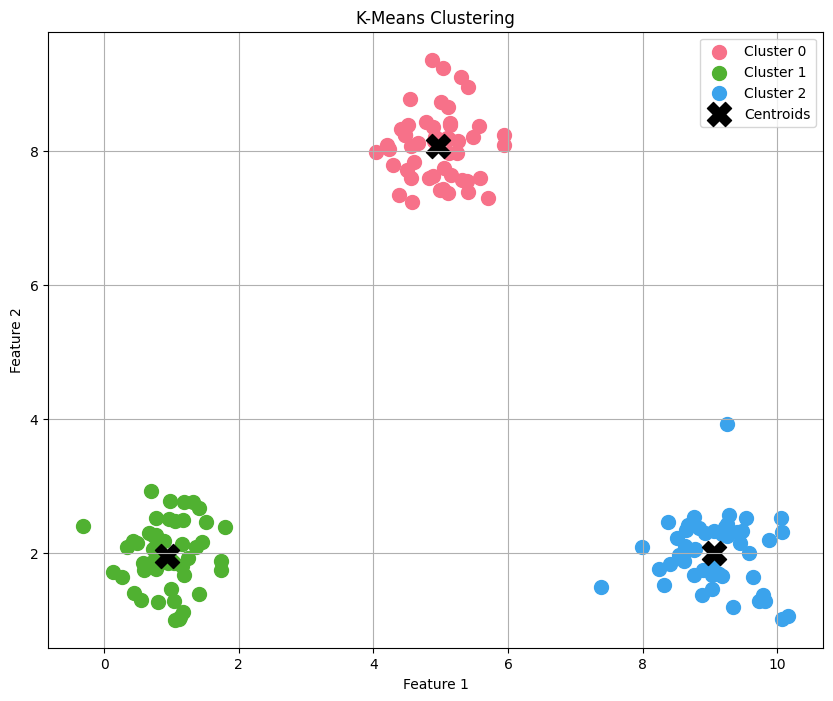

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from scipy.optimize import linear_sum_assignment

# Euclidean distance function
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

# K-Means clustering algorithm
def kmeans(data, k, max_iters=100):
    n_samples, n_features = data.shape
    # Randomly initialize centroids
    np.random.seed(42)
    centroids = data[np.random.choice(n_samples, k, replace=False)]
    
    # Initialize variables
    clusters = np.zeros(n_samples)
    prev_centroids = centroids.copy()
    
    for _ in range(max_iters):
        # Step 1: Assign clusters based on nearest centroids
        for i in range(n_samples):
            distances = [euclidean_distance(data[i], centroid) for centroid in centroids]
            clusters[i] = np.argmin(distances)
        
        # Step 2: Recalculate centroids
        for c in range(k):
            points = [data[i] for i in range(n_samples) if clusters[i] == c]
            centroids[c] = np.mean(points, axis=0) if points else centroids[c]
        
        # Check for convergence (if centroids don't change)
        if np.all(centroids == prev_centroids):
            break
        
        prev_centroids = centroids.copy()
    
    return clusters, centroids

# Function to plot clusters and centroids
def plot_clusters(data, clusters, centroids):
    plt.figure(figsize=(10, 8))
    unique_clusters = np.unique(clusters).astype(int)  # Convert to integers
    # Create a color palette
    palette = sns.color_palette("husl", len(unique_clusters))
    
    for cluster in unique_clusters:
        plt.scatter(data[clusters == cluster, 0], data[clusters == cluster, 1],
                    s=100, color=palette[cluster], label=f'Cluster {cluster}')
    
    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1],
                s=300, color='black', marker='X', label='Centroids')
    plt.title('K-Means Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Map cluster assignments to true labels using the Hungarian algorithm (to maximize accuracy)
def map_clusters_to_labels(true_labels, clusters):
    unique_clusters = np.unique(clusters)
    unique_labels = np.unique(true_labels)
    
    # Create cost matrix where each element is the number of mismatches between a cluster and a label
    cost_matrix = np.zeros((len(unique_clusters), len(unique_labels)))
    
    for i, cluster in enumerate(unique_clusters):
        for j, label in enumerate(unique_labels):
            cluster_indices = np.where(clusters == cluster)
            cost_matrix[i, j] = -np.sum(true_labels[cluster_indices] == label)
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create a mapping from clusters to labels
    cluster_label_map = {unique_clusters[row]: unique_labels[col] for row, col in zip(row_ind, col_ind)}
    return np.array([cluster_label_map[cluster] for cluster in clusters])

# Evaluation function
def evaluate_clustering(true_labels, predicted_clusters):
    predicted_labels = map_clusters_to_labels(true_labels, predicted_clusters)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    cm = confusion_matrix(true_labels, predicted_labels)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    # ROC-AUC not typically applicable for multi-class clustering, skip.

# Generate synthetic data
np.random.seed(42)
data = np.vstack([
    np.random.normal(loc=[1, 2], scale=0.5, size=(50, 2)),  # Cluster 1
    np.random.normal(loc=[5, 8], scale=0.5, size=(50, 2)),  # Cluster 2
    np.random.normal(loc=[9, 2], scale=0.5, size=(50, 2))   # Cluster 3
])
true_labels = np.array([0] * 50 + [1] * 50 + [2] * 50)

# Perform K-Means clustering
clusters, centroids = kmeans(data, k=3)

# Evaluate clustering results
evaluate_clustering(true_labels, clusters)

# Plot the clusters
plot_clusters(data, clusters, centroids)


DECISION TREE

In [25]:
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

print('Khyati Khurana')

# Function to calculate the entropy of a dataset
def entropy(labels):
    label_counts = {}
    for label in labels:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1
    total_samples = len(labels)
    entropy_value = 0
    for count in label_counts.values():
        probability = count / total_samples
        entropy_value -= probability * math.log2(probability)
    return entropy_value

# Function to calculate information gain
def information_gain(data, labels, feature_index):
    total_entropy = entropy(labels)
    feature_values = [row[feature_index] for row in data]
    unique_values = set(feature_values)
    weighted_entropy = 0
    for value in unique_values:
        subset_data = [data[i] for i in range(len(data)) if data[i][feature_index] == value]
        subset_labels = [labels[i] for i in range(len(labels)) if data[i][feature_index] == value]
        probability = len(subset_data) / len(data)
        weighted_entropy += probability * entropy(subset_labels)
    return total_entropy - weighted_entropy

# Function to find the best feature to split on
def best_feature_to_split(data, labels):
    num_features = len(data[0])
    best_feature = None
    best_gain = 0
    for feature_index in range(num_features):
        gain = information_gain(data, labels, feature_index)
        if gain > best_gain:
            best_gain = gain
            best_feature = feature_index
    return best_feature

# Function to get the majority class in a dataset
def majority_class(labels):
    label_counts = {}
    for label in labels:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1
    return max(label_counts, key=label_counts.get)

# Recursive function to build the decision tree
def build_tree(data, labels):
    # If all labels are the same, return that label
    if len(set(labels)) == 1:
        return labels[0]
    # If there are no more features to split on, return the majority class
    if len(data[0]) == 0:
        return majority_class(labels)
    # Find the best feature to split the data
    best_feature = best_feature_to_split(data, labels)
    if best_feature is None:
        return majority_class(labels)
    tree = {best_feature: {}}
    feature_values = [row[best_feature] for row in data]
    unique_values = set(feature_values)
    for value in unique_values:
        subset_data = [[row[i] for i in range(len(row)) if i != best_feature] for row in data if row[best_feature] == value]
        subset_labels = [labels[i] for i in range(len(labels)) if data[i][best_feature] == value]
        subtree = build_tree(subset_data, subset_labels)
        tree[best_feature][value] = subtree
    return tree

# Function to classify a new instance using the decision tree
def classify(tree, instance):
    if not isinstance(tree, dict):
        return tree
    feature_index = list(tree.keys())[0]
    feature_value = instance[feature_index]
    if feature_value in tree[feature_index]:
        subtree = tree[feature_index][feature_value]
        return classify(subtree, [value for i, value in enumerate(instance) if i != feature_index])
    else:
        return None

# Example usage
if __name__ == "__main__":
    # Training data: [feature1, feature2]
    train_data = [
        [1, 1], [1, 0], [0, 1], [0, 0], [1, 1], [1, 0], [0, 0]
    ]
    # Labels corresponding to the training data
    train_labels = [1, 1, 0, 0, 1, 0, 0]
    
    # Build the decision tree
    decision_tree = build_tree(train_data, train_labels)
    print(f"Decision Tree: {decision_tree}")
    
    # Test the decision tree with a new instance
    test_instance = [1, 1]  # Example instance to classify
    prediction = classify(decision_tree, test_instance)
    print(f"Prediction for {test_instance}: {prediction}")

    # Evaluate the decision tree on the training data
    predictions = [classify(decision_tree, instance) for instance in train_data]

    # Calculate metrics
    accuracy = accuracy_score(train_labels, predictions)
    precision = precision_score(train_labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(train_labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(train_labels, predictions, average='weighted', zero_division=0)
    cm = confusion_matrix(train_labels, predictions)

    print(f"\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # ROC-AUC score is not applicable for multi-class in this simple binary scenario.


Khyati Khurana
Decision Tree: {0: {0: 0, 1: {0: {0: 1, 1: 1}}}}
Prediction for [1, 1]: 1

Evaluation Metrics:
Accuracy: 0.8571
Precision: 0.8929
Recall: 0.8571
F1 Score: 0.8571
Confusion Matrix:
[[3 1]
 [0 3]]
